# MA755 - Team Sandbox

Material from _Chapter 1. End-to-end Machine Learning project_ of

> "[Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do)"<br>
by Aurélien Géron
Published by O'Reilly Media, Inc., 2017

Annotations, comments, and implementation on dataset by Angela Su, Tyler Miguel, Sebastian Bury

# Introduction

This is a College Scorecard dataset that gives various information about university and student level factors, such as college addmission, cost and finanaical aid, and student body demographics. This data is designed to "increase transparency" of "college costs and outcomes" to help students and families make informed decisions about the cost of furthering education. The data provided is aggregated at the institutional levels.


# Import Data

We start by downloading the dataset from online. To do this, we created a function to download the data from the US Department of Education website and extract the files from the zip file.

In [1]:
import os
import zipfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://ed-public-download.apps.cloud.gov/"
COLLEGE_PATH = "downloads"
COLLEGE_URL = DOWNLOAD_ROOT + COLLEGE_PATH + "/CollegeScorecard_Raw_Data.zip"
TO_PATH = "datasets/college"

def fetch_college_data(college_url=COLLEGE_URL, to_path=TO_PATH):
    os.makedirs(to_path, exist_ok=True)
    zip_path = os.path.join(to_path, "CollegeScorecard_Raw_Data.zip")
    urllib.request.urlretrieve(college_url, zip_path)
    college_zip = zipfile.ZipFile(zip_path)
    college_zip.extractall(path=to_path)
    college_zip.close()

In [54]:
fetch_college_data()

The file `CollegeScorecard_Raw_Data.zip` is downloaded into the `datasets/college` directory. The unzipped `CollegeScorecard_Raw_Data` is created in the same directory. The file `MERGED2012_13_PP.csv`, which contains the most recent earnings data from College Scorecard data is stored in the `CollegeScorecard_Raw_Data` directory. 

We will load `MERGED2012_13_PP.csv` into our notebook. Additionally, we will load `MERGED2014_15_PP.csv` into our notebook so that we can extract key descriptive information about the universities that is not present in the `MERGED2012_13_PP.csv` file. 

In addition to loading the CSV into our notebook, we will do some data cleaning within our `load_college_data()` function to ensure the data structure of the features in the CSV file. Specifically, we noticed the file contained the string value "PrivacySuppressed" in many numeric fields. We converted these to `NaN` values. Furthermore, some of the string values in our dataframe were not rendering correct, so we explicitly stated the `dtype` of three columns, `ZIP`, `NPCURL`, and `ALIAS`.


In [2]:
import pandas as pd

def load_college_data(file, data_path=TO_PATH):
    csv_path = os.path.join(data_path, "CollegeScoreCard_Raw_Data",
                            file)
    # return Panda DataFrame with all data
    return pd.read_csv(csv_path, na_values = "PrivacySuppressed", 
                       dtype = {'ZIP':str,
                                'NPCURL':str,
                                'ALIAS':str})

Load the data from the `MERGED2012_13_PP.csv` and `MERGED2014_15_PP.csv` file into a `DataFrame` Pandas object stored in `college`. 

In [3]:
college_1213 = load_college_data(file='MERGED2012_13_PP.csv')
college_1415 = load_college_data(file='MERGED2014_15_PP.csv')
print(type(college_1213))
college_1213.head()

<class 'pandas.core.frame.DataFrame'>


,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,0.000000,1133.0,NaN,NaN,1,0.4879,0.5121,1405.0,1574.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,0.290236,1485.0,NaN,NaN,1,0.4200,0.5800,3153.0,3481.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,0.000000,1.0,NaN,NaN,1,0.4379,0.5621,264.0,336.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,0.307116,801.0,NaN,NaN,1,0.5425,0.4575,1208.0,1392.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,NaN,0.000000,1298.0,NaN,NaN,1,0.4046,0.5954,1951.0,1961.0


Each row is an institution with 1743 attributes as columns.

In [4]:
college_1213.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793 entries, 0 to 7792
Columns: 1743 entries, ﻿UNITID to CDR2_DENOM
dtypes: float64(1724), int64(11), object(8)
memory usage: 103.6+ MB


This `.info()` method returns a brief description of the dataset, with each attribute from the columns and the type of the object. For example, we can see that the data in our `college` dataframe has 1724 float attributes, 11 integer attributes, and 8 object attributes (in our case, string or factor attributes).

# Variable Selection

Given the size of our dataset, we utilized the [College Data Documentation Report](http://https://collegescorecard.ed.gov/data/documentation/) to select our variables of interest. From this document, we were able to select variables of interest to answer our research question: how can we predict the Median income of a student 10 years out of college by using university factors. 


The variables we selected are:

University Description:
- INSTNM (institution name)
- CITY (the city of the school)
- STABBR (state postcode)
- ZIP (zip code)
- LATITUDE (latitude of location)
- LONGITUDE (longitude of location)

Features:
Factor variables
- ADM_RATE (admission rate as a percent)
--- turn into binaray (highly selective, selective, moderate, less than, non-selective
- MAIN (flag for main campus)
--- main branch
- ICLEVEL (highest level of award: 4-year, 2-year, less than 2-year)
--- level of school
- Control (Public, Private Non-profit, or Private For-Profit)
--- whether it is public or non
- HBCU= Historically black college
- PBI= Predominantly black college
- ANNHI= Alaska Native-/Native Hawaiian-serving Institutions
- TRIBAL= Tribal Colleges and Universities
- AANAPII= Asian American-/Native American-Pacific Islander-serving Institutions
- HSI= Hispanic-serving Institutions
- NANTI= Native American Non-Tribal-serving institution

Label data: 
- MN_EARN_WNE_P10 (Mean Earnings 10 years after college)

The university description variables were chosen to give a basic idea of the universty name and location, both the geographic latitude and longitude as well as city and zip in the state. The factor variables such as admission rate, level of award, and public/private can be correlated to see how these influence median income later for a student on in life. These basic factors were chosen since they give a profile of the school and could relate to later success, as do labels like "historically black college" and other racial indiciators. 

Due to the avaialable data in the `MERGED2012_13_PP.csv`, we had to load the `MERGED2014_15_PP.csv` file to extract longitude, latitude, HBCU, PBI, ANNHI, TRIBAL, AANAPII, HSI, and the NANT variables.

Below, we used both files to extract data and combine to what we will use moving forward. We will extract description data and the data we will use to explore relationships.

In [9]:
inst_1213 = college_1213.loc[:,['INSTNM','CITY','STABBR',
                                     'ZIP','ADM_RATE', 
                                     'MAIN','ICLEVEL',
                                     'CONTROL','MN_EARN_WNE_P10']]

inst_1415 = college_1415.loc[:, ['INSTNM', 'HBCU','PBI',
                                 'ANNHI', 'TRIBAL','AANAPII',
                                 'HSI', 'NANTI', 'LATITUDE','LONGITUDE']]

college = pd.merge(inst_1213, inst_1415, on=['INSTNM'])

Now that we have the variables we want, we will look take a look at our data set and check for missing values

# Remove missing data

First we will examine out dataset to see the spread of missing data.

In [10]:
college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7789 entries, 0 to 7788
Data columns (total 18 columns):
INSTNM             7789 non-null object
CITY               7789 non-null object
STABBR             7789 non-null object
ZIP                7789 non-null object
ADM_RATE           2359 non-null float64
MAIN               7789 non-null int64
ICLEVEL            7789 non-null int64
CONTROL            7789 non-null int64
MN_EARN_WNE_P10    6064 non-null float64
HBCU               7320 non-null float64
PBI                7320 non-null float64
ANNHI              7320 non-null float64
TRIBAL             7320 non-null float64
AANAPII            7320 non-null float64
HSI                7320 non-null float64
NANTI              7320 non-null float64
LATITUDE           7320 non-null float64
LONGITUDE          7320 non-null float64
dtypes: float64(11), int64(3), object(4)
memory usage: 1.1+ MB


It appears that `ADM_RATE` has a large amount of missing values. There are three options to account for missing values, we can:

Option 1: removes the corresponding institutions  
Option 2: removes the entire attribute  
Option 3: sets the values to something else (0, mean or median, etc.)

Given that over 60% of the admission rate data is empty, we will remove the institutions that don't have this data available. If we chose to fill in the attribute with a value, such as the median, we believe that we would significantly alter our predictions. 

The goal of this analysis is to predict `MN_EARN_WNE_P10`, so we want to esnure we have a full working sample of data before moving on.

In [11]:
college.dropna(subset=['ADM_RATE']).isnull().sum()

INSTNM               0
CITY                 0
STABBR               0
ZIP                  0
ADM_RATE             0
MAIN                 0
ICLEVEL              0
CONTROL              0
MN_EARN_WNE_P10    209
HBCU                11
PBI                 11
ANNHI               11
TRIBAL              11
AANAPII             11
HSI                 11
NANTI               11
LATITUDE            11
LONGITUDE           11
dtype: int64

As we can see above, if we drop the subset of institutions in `ADM_RATE` that has missing data, we will significantly decrease the number of missing values. However, there are still a large portion of missing values in our label variable. We will need those values to train our model.

We will take a look at dropping those institutions with missing data also.

In [8]:
college.dropna(subset=['ADM_RATE', 'MN_EARN_WNE_P10']).isnull().sum()

INSTNM              0
CITY                0
STABBR              0
ZIP                 0
ADM_RATE            0
MAIN                0
ICLEVEL             0
CONTROL             0
MN_EARN_WNE_P10     0
HBCU               10
PBI                10
ANNHI              10
TRIBAL             10
AANAPII            10
HSI                10
NANTI              10
LATITUDE           10
LONGITUDE          10
dtype: int64

There are only a few more peices of missing data. We will remove those also, starting with `HBCU`. 

In [62]:
college.dropna(subset=['ADM_RATE', 
                       'MN_EARN_WNE_P10',
                       'HBCU']).isnull().sum()

INSTNM             0
CITY               0
STABBR             0
ZIP                0
ADM_RATE           0
MAIN               0
ICLEVEL            0
CONTROL            0
MN_EARN_WNE_P10    0
HBCU               0
PBI                0
ANNHI              0
TRIBAL             0
AANAPII            0
HSI                0
NANTI              0
LATITUDE           0
LONGITUDE          0
dtype: int64

It looks like our dataset is finally good to move on. We will store this new dataset into a new object and reset the index of the rows.

In [12]:
college = college.dropna(subset=['ADM_RATE', 
                                 'MN_EARN_WNE_P10',
                                 'HBCU'])

college = college.reset_index(drop=True)

To get a better understanding of the institutions in our dataset, we took a look at the types of institutions in our dataset. The `CONTROL` attribute denote the type of institution Public (1), Private Non-Profit (2), or Private For-Profit (3).

# Examine new sample

In [13]:
college['CONTROL'].value_counts()

2    1090
1     588
3     462
Name: CONTROL, dtype: int64

Based on our sample of data, we have 1,090 Private Non-Profit institutions, which make up about 50% of our data.

As we can see, `CONTROL` is a categorical variable represented as a integer variable. We can get a better understanding if we convert this variable into it's categorical meaning. Additioanlly, we can see that `ICLEVEL` is a categorical variable represeting the level of the instituion (Four-year, Two-year, Less than two-year). We will also look to convert this variable to a categorical variable too.

# Create categorical variables

We will use a `for` loop to itterate over the two variables in the dataframe. We will write the output to an empty list.

In [14]:
iclevel_cat = []

for i in college['ICLEVEL'].index:
    if college['ICLEVEL'][i] == 1:
        iclevel_cat.append('FOUR_YEAR')
    elif college['ICLEVEL'][i] == 2:
        iclevel_cat.append('TWO_YEAR')
    else:
        iclevel_cat.append('LESS_THAN_TWO_YEAR')

In [15]:
control_cat = []

for i in college['CONTROL'].index:
    if college['CONTROL'][i] == 1:
        control_cat.append('Public')
    elif college['CONTROL'][i] == 2:
        control_cat.append('Private_non_pofit')
    else:
        control_cat.append('Private_for_profit')

Now we will take the two new lists, and overwrite the dataframe.

In [16]:
college['ICLEVEL'] = iclevel_cat
college['CONTROL'] = control_cat

In [17]:
college['CONTROL'].value_counts()

Private_non_pofit     1090
Public                 588
Private_for_profit     462
Name: CONTROL, dtype: int64

Now we can see that the integers 1, 2, and 3, were replaced with text strings.

# Plot Histograms

Histograms are plotted for the numerical attributes, either individually or for the whole dataset.

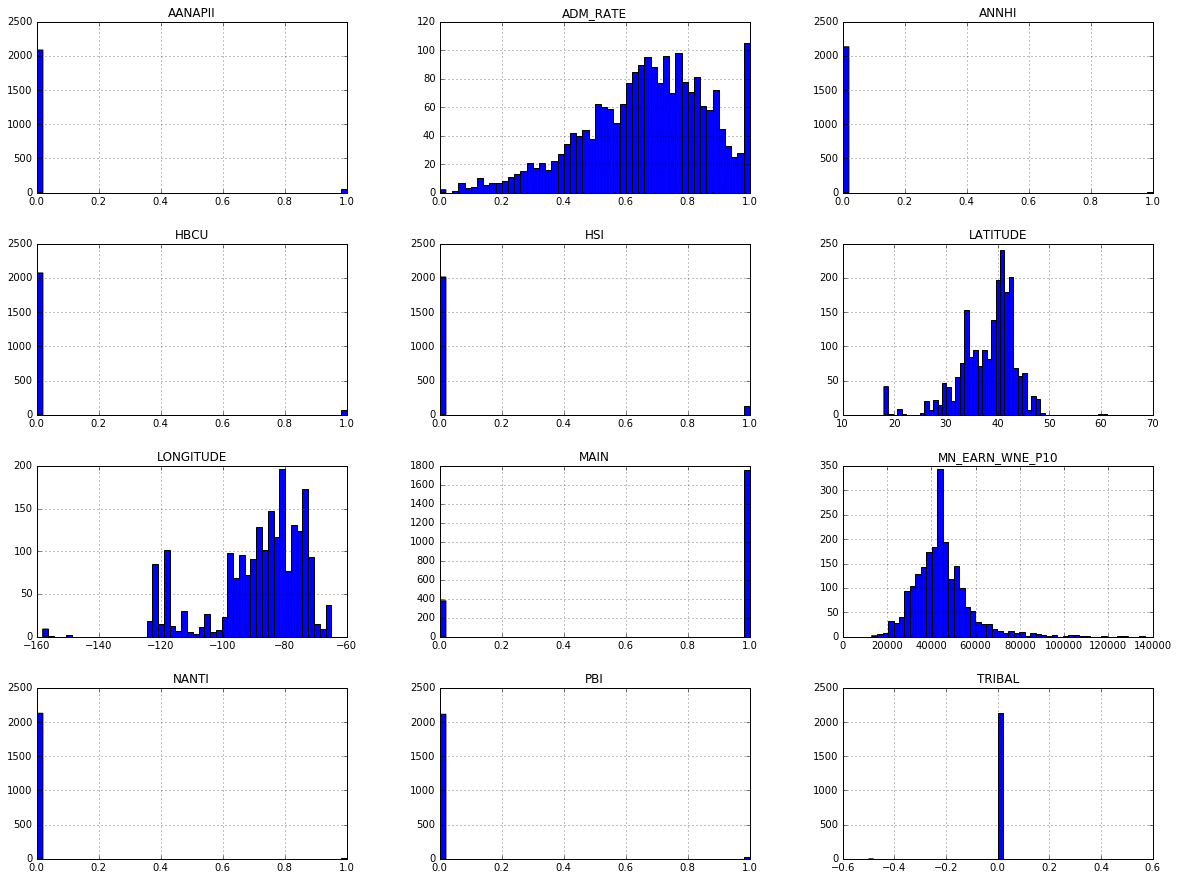

In [27]:
%matplotlib inline 
import matplotlib.pyplot as plt
college.hist(bins=50, figsize=(20,15))
plt.show()

# Subset into Train and Test

Split the dataset into a train set and a test set. This test set is to prevent overfitting.

The dataset is split into subsets and there are new features such as random_state for the random generator seed when randomizing the train-test split of the data.

In [28]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(college, test_size=0.2, random_state=70)

Now that we have a trianing and test set, we can look at the breakdown.

In [29]:
print(len(train_set), "train +", len(test_set), "test")

1712 train + 428 test


There are 1,712 institutions in our trianing set and 428 in our test set.

# Visualize data

Here we explore the data for insights. The test set is put aside by making a copy without chaning the training set.

In [30]:
college_tr = train_set.copy()

The geographical data is visualized in a scatterplot with latititude and longitude.

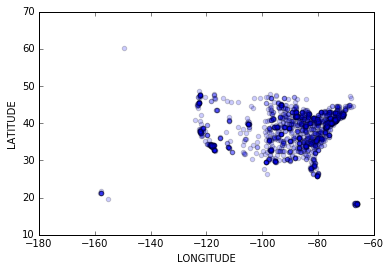

In [31]:
college_tr.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", alpha =0.2)

We can see that the majority of colleges are located in the east side of the United States. However, it appears that there are colleges from US territories (such as Puerto Rico), Hawaii. and Alaska.

## Correlation
This computes the standard coefficient between every pair of attributes

In [32]:
corr_matrix = college_tr.corr()

Here we see how each attribute compares with the `MN_EARN_WNE_P10`.
It's a range from -1 to 1. Values close to 1 or -1 show a strong positive or negative correlation respectivly. 

In [33]:
corr_matrix["MN_EARN_WNE_P10"].sort_values(ascending=False)

MN_EARN_WNE_P10    1.000000
LATITUDE           0.219002
MAIN               0.127084
AANAPII            0.090932
LONGITUDE          0.029357
ANNHI             -0.030211
PBI               -0.032672
NANTI             -0.036305
HSI               -0.037623
HBCU              -0.127322
ADM_RATE          -0.346357
TRIBAL                  NaN
Name: MN_EARN_WNE_P10, dtype: float64

As we see above `ADM_RATE` and `LATITUDE` are the most closely correlated correlated variables. However, they both form a weak to moderate correlation. Specifically, `ADM_RATE` is negatively corrected, that is, when `ADM_RATE` increases, `MN_EARN_WNE_P10` generally decreases. 

All the other attriutes aren't very correlated in either direction. 

This uses Pandas to check for correlation and creates scatterplots of the attributes, specifically focusing on `ADM_RATE`, `LATITUDE` and `MN_EARN_WNE_P10` since they seem more promising than others based on our results above. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128ffdb70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a95c4e0>]], dtype=object)

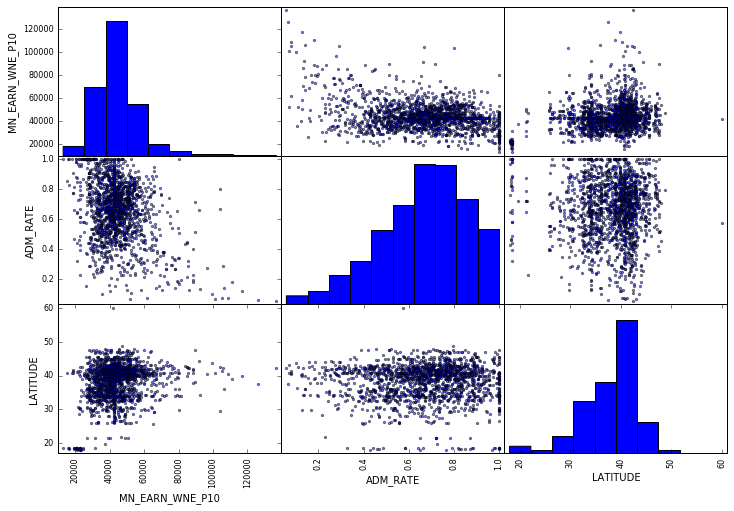

In [34]:
from pandas.tools.plotting import scatter_matrix

attributes = ["MN_EARN_WNE_P10", "ADM_RATE", "LATITUDE"]
scatter_matrix(college_tr[attributes], figsize=(12, 8))

Here we make a bigger scatterplot of `ADM_RATE` and `MN_EARN_WNE_P10` where we can see it better.

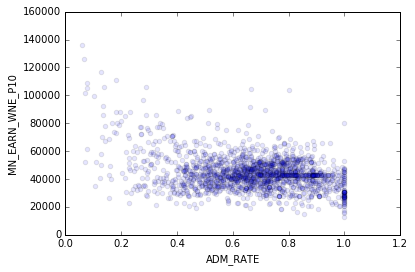

In [35]:
college_tr.plot(kind="scatter", x="ADM_RATE", y="MN_EARN_WNE_P10",
             alpha=0.1)

The correlation between `ADM_RATE` and `MN_EARN_WNE_P10` seems to be a weak negative correlation. This makes sense since if the admission rate is lower, such as a `7%` that Harvard has, the schools are more competitive and should output higher-performing workers. A school with a less than `10%` acceptance rate had nearly `$140,000` of income. There are also less schools with lower admission rates since that is reserved for Ivys or other competitive schools. The bulk of the schools are in the `50-80%` range and yield incomes closer to a median of `$40,000`. The schools that accept `100%` of applicants, such as the for-profit schools, have an income closer to `$20,000-30,000` for students in 10 years.  

Next we look at another relationship to see if longitude has any impact on the median income in 10 years. 

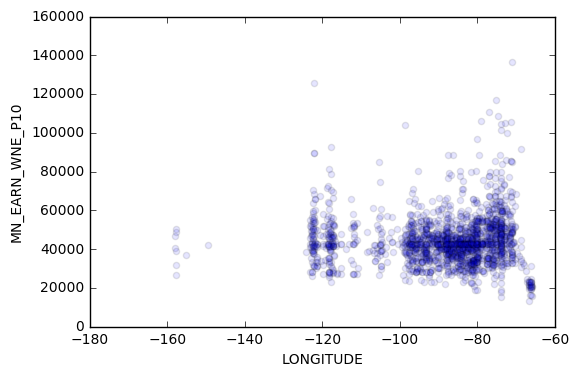

In [106]:
college_tr.plot(kind="scatter", x="LONGITUDE", y="MN_EARN_WNE_P10",
             alpha=0.1)

The correlation between `LONGITUDE` and `MN_EARN_WNE_P10` is unclear at first. A longitude of `-120` is approximately the west coast (LA is `-118`), while the east coast is the `-70` side (Boston is `-71`). We found earlier that most schools are closer to the east coast. However this graph shows that this does not impact the median income in 10 years much. If anything, it shows that the midwest, between `-100` and `-115` degrees latitude, have less schools. There are outliers that have high incomes over `$120,000`  on the extremities, the very east and west coast. This may be cities like San Francisco and New York with high standands/costs of living, which translates to higher salary. Otherwise, a salary of around `$40,000` seems to be the median across the board, with a distinct `$20,000` tier that is more present on the east coast closer to the longitude of Maine, which is less populated and cheaper to live in.

## Cleaning Up the Data

Here we revert to a clean set of our data to prepare for machine learning algorithms since we added things from before. We copy the `train_set` from before and then separate the predictors and labels. 

In [36]:
college_tr.columns

Index(['INSTNM', 'CITY', 'STABBR', 'ZIP', 'ADM_RATE', 'MAIN', 'ICLEVEL',
       'CONTROL', 'MN_EARN_WNE_P10', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL',
       'AANAPII', 'HSI', 'NANTI', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [37]:
college_features = college_tr[['ADM_RATE', 'MAIN', 'ICLEVEL',
                             'CONTROL', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL',
                             'AANAPII', 'HSI', 'NANTI','LATITUDE', 'LONGITUDE']].copy()
college_labels = college_tr["MN_EARN_WNE_P10"].copy()
print(college_features.shape)
print(college_labels.shape)

(1712, 13)
(1712,)


Returns the first 5 rows of our DataFrame.

In [38]:
college_features.head()

,ADM_RATE,MAIN,ICLEVEL,CONTROL,HBCU,PBI,ANNHI,TRIBAL,AANAPII,HSI,NANTI,LATITUDE,LONGITUDE
368,0.7232,1,FOUR_YEAR,Public,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21.354897,-158.061825
981,0.0695,1,FOUR_YEAR,Private_non_pofit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.808286,-73.961885
717,0.6995,1,FOUR_YEAR,Public,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.628861,-71.005528
1202,1.0000,1,FOUR_YEAR,Private_non_pofit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.115484,-84.506036
910,0.8063,1,FOUR_YEAR,Public,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36.106994,-115.141153


### Label Encoder

Here we convert the text labels into numbers using the LabelEncoder. This is because it is easier to do machine learning on numbers instead of text (unless you're doing something text specific of course)

In [39]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
college_cat = college_tr["ICLEVEL"]
college_cat_encoded = encoder.fit_transform(college_cat)
college_cat_encoded

array([0, 0, 0, ..., 0, 0, 0])

Shows the names of values encoded (into 0, 1, ...)

In [40]:
print(encoder.classes_)

['FOUR_YEAR' 'LESS_THAN_TWO_YEAR' 'TWO_YEAR']


# Hot encoding

Hot encoding is better since everything is only a 1 or a 0, this is what the OneHotEncoder does. This keeps the algorithms from thinking that values that are close together are more similar than ones farther apart which could happen when things are encoded as 0,1,2,3,4...

In [41]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
college_cat_1hot = encoder.fit_transform(college_cat_encoded.reshape(-1,1))
college_cat_1hot

<1712x3 sparse matrix of type '<class 'numpy.float64'>'
	with 1712 stored elements in Compressed Sparse Row format>

In [42]:
college_cat_1hot.toarray()

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

This converts text to integer to one hot vectors all at once. 

In [43]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
college_cat_1hot = encoder.fit_transform(college_cat)
college_cat_1hot

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ..., 
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

We were able to do this to just one of the variables `ICLEVEL` here, however, we will also convert `CONTROL` later via a our pipeline which we will create.

### Custom transformers

Although Scikit-Learn provides many useful transformers, we will need to write our own for tasks such as custom cleanup operations or combining specific attributes. 

Since Scikit-Learn relies on duck typing (not inheritance), all we need is to create a class and implement three methods: fit() (returning self), transform() and fit_transform(). 

`class` is similar to `def` for functions. `class` is used to define a class. A class is a grouping of data and functions that are stored in a container to be accessed via the dot operator. These functions defined in the class are methods.

Since Scikit-Learn does not know how to handle Pandas DataFrames, we will create a new class called `DataFrameSelector` to support us in building our pipeline. The `DataFrameSelector` class we create will use `BaseEstimator` and `TransformerMixin` as a base case, and take three functions. 

The `transform()` method will take a list of attributes from a dataframe and select the values within this list, which we will use in the next code chunk to build a new pipeline.

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


Below, we use a Pipeline constructor that takes a list of names and estimator pairs and uses them to define a sequence of steps. All the name/estimator combinations are transformers, except for the last one.

We will use the code below to combine our pipeline for numeric data with a pipeline for our categorical data.

First, we import `FeatureUnion` which we can give a list of transformers, and when its `transform()` method is called it runs each transformer’s `transform()` method at the same time, waits for their output, then concatenates them and returns the result. 

We pull the names of the attributes of the `college_features` dataframe and put them in `num_attribs`. Given that we have two categorical attribute, we will assign them to `cat_attribs`. Lastly, because our binary attributes in our data set are already prepared for analysis, we will just add them into the pipeline as is, and combine them with the result.

Since we have `DataFrameSelector` which will select the attributes from the dataset that match `college_tr` we will be able to reuse this pipeline later down the line for our test data. 

Finally, once all the transformations are complete, we will append the pipelines together to reform the dataset.

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
import numpy as np

num_attribs = list(college_features[['ADM_RATE', 'LATITUDE', 'LONGITUDE']])
bin_attribs = list(college_features.drop(['ADM_RATE', 'LATITUDE',
                                          'LONGITUDE','ICLEVEL',
                                          'CONTROL'],axis=1))
cat_attribs = list(college_features[['ICLEVEL','CONTROL']])

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

bin_pipeline = Pipeline([
        ('selector', DataFrameSelector(bin_attribs))
    ])

cat_pipeline_1 = Pipeline([
        ('selector', DataFrameSelector(cat_attribs[0])),
        ('label_binarizer', LabelBinarizer()),
    ])

cat_pipeline_2 = Pipeline([
        ('selector', DataFrameSelector(cat_attribs[1])),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("bin_pipeline", bin_pipeline),
        ("cat_pipeline_1", cat_pipeline_1),
        ("cat_pipeline_2", cat_pipeline_2),
    ])

college_prep = full_pipeline.fit_transform(college_tr)
college_prep

array([[ 0.28040559, -3.13539434, -4.55436281, ...,  0.        ,
         0.        ,  1.        ],
       [-3.03846553,  0.5005565 ,  0.96729637, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.16007938,  0.65392671,  1.16139872, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [-0.75226748,  0.45597779,  0.570072  , ...,  0.        ,
         1.        ,  0.        ],
       [-0.64768014, -0.54648444,  0.69749124, ...,  0.        ,
         1.        ,  0.        ],
       [-1.12949269,  0.30290439, -1.08545332, ...,  0.        ,
         0.        ,  1.        ]])

Calling `full_pipeline.fit_transform(college_tr)` will call the `num_pipeline`, `bin_pipeline`, `cat_pipeline_1` and `cat_pipeline_2` and transform the data and return the nd.array.

# Linear Regression Model

Our first model we will train is a linear regression model. Here we import the `LinearRegression` class from scikit-learn.

We will regress our `college_labels` data (target values) onto our transformed `college_full_prep` data (training data).

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(college_prep, college_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now we can use our model to make some predictions on the mean salary 10 year after graduation. Below we pull just the first 5 observations from the college_features data and college_labels data. Then we prepare the college data for the regression model, using `full_pipeline.transfrome()`.

Once we have prepared the data, we use our linear regression model that we just fitted, and predict the mean earnings 10 years after graduation, which is our labels, and print it to the console. Additionally, we can compare these predictions with our actual observed mean earnings by printing our label data.

In [47]:
some_data = college_features.iloc[:5]
some_labels = college_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 46336.  59648.  48384.  39936.  50176.]
Labels:		 [40300.0, 101400.0, 48500.0, 31300.0, 47600.0]


As we can see above, it appears that our predictions are fairly close to our actual observed, except for our second, which is off by over \$40,000! labels.

We now want to examine how well the linear regression model fits our data. We will use the RMSE to do this by first passing our `college_prep` data through `lin_reg.predict()`. Then we will compute the mean squared error of our prediction data by comparing it to our observed label data. Finally, we will take the square root of the value and print it to the console.

In [48]:
from sklearn.metrics import mean_squared_error
college_predictions = lin_reg.predict(college_prep)
lin_mse = mean_squared_error(college_labels, college_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

10855.188565584318

Based on the data, we notice a prediction error of \$10,832. Given that most of the median earnings values are \$36,000 and \$50,000, this error could be as large as 33%.

# Decision Tree Regression Model

The second model we will train is a regression tree model. Here we import the `DecisionTreeRegressor` class from scikit-learn.

We will fit our model by using the `college_prep` training data to train our tree model to predict our `college_labels` data (target values). The code below is similar to our odinary least squares regression model we ran using the `LinearRegression` class.

In [49]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(college_prep, college_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

Similary to our first regression model, we would like to examine how well the regression tree model fits our data. 

We will use the RMSE to do this by first passing our `college` data through `tree_reg.predict()`. Then we will compute the mean squared error of our prediction data by comparing it to our observed label data. Finally, we will take the square root of the value and print it to the console.

In [50]:
college_predictions = tree_reg.predict(college_prep)
tree_mse = mean_squared_error(college_labels, college_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Based on the data, we notice a prediction error of 0. This appears that either our model is prefect, or we have overfit our model. 

# Cross-Validation

Normally, we would split our training data to have a valiadataion dataset. Instead, we will use scikit-learn’s cross-validation feature and perform K-fold cross-validation which randomly splits the training set into 10 distinct subsets, each called a fold, then it trains and evaluates the decision tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. 

The output is an array containing the 10 evaluation scores.


## Cross Validation: Decision Tree Regression Model

The `cross_val_score()` function takes `tree_reg` (our regression tree estimator), `college_prep` (our training data), `college_labels` (our target variable), our `scoring method` (neg_mean_squared_error), and `cv` which splits our data into 10 folds.

Finally, we take the square root of the resulting array. Given that our tree_scores array is comprised of negative numbers, we multiple the array by -1 then square root the array, otherwise, we would get NaN values. 

In [51]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, college_prep, college_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

The following function was designed to take our `tree_rmse_scores` array and ourput the scores, mean score, and standard deviation of our scores.

In [52]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)


Scores: [ 13328.15475984  12970.02133724  13651.2557527   13861.51430932
  14005.22250127  12272.30038441  14555.17230869  14585.12019128
  14935.13068758  15411.60229762]
Mean: 13957.549453
Standard deviation: 902.089687111


Based on ond scores, it seems that our linear regression performed better when we compare the mean RMSE of the regression tree to the RMSE of the linear regression model.

## Cross Validation: Linear Regression Model

Computing the the K-fold cross validation scores for the linear regression model yields similar results as our first linear regression model.

In [53]:
lin_scores = cross_val_score(lin_reg, college_prep, college_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 10860.42604843  11536.46856992  10565.78468365  10673.2750889
  10821.32262618  10950.34589248   9596.05523728  10715.24903237
  11316.28338102  12152.68082378]
Mean: 10918.7891384
Standard deviation: 636.542448373


The mean RMSE is about 10907, indicating a mean error rate of \$10,907 in our mean earnings predictions. This is a bit worse than our first linear regression model.

# Random Forest Model

Our final model we train is a Random Forest Model.

Random Forests work by training many decision trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning and it is often a great way to push ML algorithms even further. 

The code below is similar to our previous model's code. We start with importing the `RandomForestRegressor` class, fit our model with our training and label data, make predictions, compute the mean squared error and then perform a K-fold cross validation with 10 folds.

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(college_prep, college_labels)
forest_predictions = forest_reg.predict(college_prep)
forest_mse = mean_squared_error(college_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_scores = cross_val_score(forest_reg, college_prep, college_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print(forest_rmse)
print(display_scores(forest_rmse_scores))

4604.57192928
Scores: [  9648.69460384  10456.96966309   9931.13053993  10322.82490577
  10654.45287576  10427.297761    11004.28048029  11379.32705438
  11144.00935231  10937.28375893]
Mean: 10590.6270995
Standard deviation: 515.951990189
None


We have printed out the RMSE and the K-fold scores. As we can see Random Forests appear to be a bit better than the previous two models (10671 error vs 10907 in linear regression). However, the score on the training set is still a bit too high.

# Grid Search

Using Scikit-Learn’s `GridSearchCV`, we will search for the best hyperparameters values. 

First, we import the `GridSearchCV` class. Next we state which hyperparameters you want it to experiment with and which values to test. In our case, we will go through 18 possible cominbation. First `GridSearchCV` will evaluate all combinations of `n_estimators` and `max_features` hyperparameter in the first dict, and then then try all combinations of hyperparameter values in the second dict but this time with the bootstrap hyperparameter set to False instead of True. 

Each combination will be evaluated using cross-validation, training each model 5 times given we set the cross-validation equal to 5.

The `GridSearchCV` takes an estimator (`forest_reg`), param_grid (`param_grid`), cross-validation strategy (5), and a scoring method (`neg_mean_squared_error`).

We ill use the `grid_search.fit` on our training predictor data and our training label data.

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(college_prep, college_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

After we run `grid_search.fit()`, we are able to look at the results using `grid_search.best_params_`. The output here gives our max features and number of estimators.

In [56]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

Since our number of estimators matches our max value that we gave param_grid, we will considering re-runing the grid search as higher values of the possible number of estimators to see if the search improves.

Instead of manually specifying the number of parameters to try, we can use `grid_search.best_estimator_` to find the best number of estimators.

In [57]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Here we can see that the best number of estimators is set to 30 and the maximum features is 2.

Addtionally, we can take our grid search results and store them in a dictionay, `cvres`. 

The for loop states that for each mean score and paramaters in the zipped tuple containing `cvres["mean_test_score"]` and `cvres["params"]`, print the square root of the mean score (multiplied by -1) and the parameters, as a tuple. Here, `zip` returns and iterator of tuples from `cvres["mean_test_score"]` and `cvres["params"]`.

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

11283.3722741 {'max_features': 2, 'n_estimators': 3}
10399.0487214 {'max_features': 2, 'n_estimators': 10}
10219.3256346 {'max_features': 2, 'n_estimators': 30}
11493.4082253 {'max_features': 4, 'n_estimators': 3}
10587.283588 {'max_features': 4, 'n_estimators': 10}
10240.2493405 {'max_features': 4, 'n_estimators': 30}
11922.7359389 {'max_features': 6, 'n_estimators': 3}
10573.9848886 {'max_features': 6, 'n_estimators': 10}
10231.6223258 {'max_features': 6, 'n_estimators': 30}
11548.6984158 {'max_features': 8, 'n_estimators': 3}
10811.2073156 {'max_features': 8, 'n_estimators': 10}
10357.3947017 {'max_features': 8, 'n_estimators': 30}
11824.3332948 {'max_features': 2, 'n_estimators': 3, 'bootstrap': False}
10691.0677545 {'max_features': 2, 'n_estimators': 10, 'bootstrap': False}
11632.4804537 {'max_features': 3, 'n_estimators': 3, 'bootstrap': False}
11074.4539089 {'max_features': 3, 'n_estimators': 10, 'bootstrap': False}
11594.6384689 {'max_features': 4, 'n_estimators': 3, 'bootstrap

From the results, we can see that the best solution is obtained by setting the max_features hyperparameter to 2, and the `n_estimators` hyperparameter to 30. This is decision by selecting the results with the lowest `mean_test_score`.

The RMSE score for this combination is 10,130, which is slightly better than the score we got earlier using the default hyperparameter values.

The `RandomForestRegressor` can indicate the relative importance of each attribute for making accurate predictions. Below we use the `grid_search.best_estimator_.feature_importances_` to pull out the array of "importantamce scores" that are associated with each attribute.

Then we set up the list of variables by creating a list of the extra variables we added to the dataset and combining it with the numeric attributes and the categorical attributes that wer encoded. 

The 'zip()' function creates a tuple of feature importance and the attribute name and then the `sorted()` function where `reverse=True` sorts the values in decending order by `feature_importance`.

In [59]:
feature_importances = grid_search.best_estimator_.feature_importances_
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33887435161441554, 'ADM_RATE'),
 (0.24623782273609046, 'LONGITUDE'),
 (0.23371838824876837, 'LATITUDE'),
 (0.020871861195798494, 'LESS_THAN_TWO_YEAR'),
 (0.012026891320088091, 'FOUR_YEAR'),
 (0.003868658099131186, 'TWO_YEAR')]

As we can see, admission rate, longitude, and latitude are the most important features in our dataset.

Finally, we put it all together in this final model. We use the `grid_search.best_estimator_` as our final model given its performance rated by its lowest RMSE. 

The `X_test` is our predictor test dataset after dropping the `MN_EARN_WNE_P10`. The `y_test` is the label test data. We use the `full_pipeline.transform()` to transform the data for our model, creating new derived attributes, replacing the missing numeric values with the median values for that attribute, and standarizing the numeric variables.

In [60]:
final_model = grid_search.best_estimator_

x_test = test_set[['ADM_RATE', 'MAIN', 'ICLEVEL',
                             'CONTROL', 'HBCU', 'PBI', 'ANNHI', 'TRIBAL',
                             'AANAPII', 'HSI', 'NANTI','LATITUDE', 'LONGITUDE']].copy()
y_test = test_set["MN_EARN_WNE_P10"].copy()


# need to build the pipeline to transform test data
x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

10738.887697631762

Our final model performed better on our test than it did on our training data. A smaller RMSE of 10616.42.

# Extension

Although we decided on our final model being the random forest model, based off of the model's RMSE, we extended our analysis to evaluate how the linear regression model and the decision tree regression model

In [61]:
linear_model_predictions = lin_reg.predict(x_test_prepared)
lin_mse = mean_squared_error(y_test, linear_model_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

11390.308753292296

As we can see from our linear regression model, the RMSE is higher than our random forest model on our test set.

In [62]:
decisiontree_model_predictions = tree_reg.predict(x_test_prepared)
tree_mse = mean_squared_error(y_test, decisiontree_model_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

15299.394496600735

As we can see from our linear regression model, the RMSE is higher than our random forest model on our test set.